# Assignment Module 3: Quantum Neural Networks (QNN)

This assignment focuses on quantum neural networks (QNNs) for binary classification using a PennyLane + PyTorch implementation of a fully quantum classifier. To complete the assignment, you will implement missing code (marked **YOUR CODE HERE**) and answer a set of short theoretical questions.


## Preparation

* Look at the notebooks and slides on **Quantum Neural Networks (QNNs)** and **PennyLane-PyTorch integration** provided in this module.


## Use of generative AI tools

You may use AI-based tools (e.g., ChatGPT, GitHub Copilot, Claude, Gemini, DeepSeek, ...) for brainstorming, refactoring, coding assistance, plotting, or editing.

This is allowed with disclosure. LLMs are a great tool, but you have to make sure to grasp the contents of the course!

**Make sure to fill in the mandatory AI-disclosure in the notebook before submitting!**


## Preparatory code

Run this cell to import the modules we need.


In [1]:
# Reproducibility
SEED = 123

# Imports
import math, sys, os, json, pathlib
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

import pennylane as qml
from pennylane import numpy as pnp  # optional

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

print("pennylane version: ", qml.__version__)
print("torch version:     ", torch.__version__)


# no need to use GPU for this assignment
device_torch = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch device:", device_torch)

print("Imports OK")

FP_TOL = 0.05  # floating point tolerance for automated tests


pennylane version:  0.43.1
torch version:      2.9.0+cu128
Torch device: cuda
Imports OK


# Task 0: Loading the dataset

In this exercise, we will use the digits dataset from scikit-learn, but we restrict ourselves to a binary classification problem (two digits only, e.g., digits 0 and 1).

Before designing the QNN, we must first:

1. Load the dataset and select only two classes (0 and 1).  
2. Split the data points into a training, validation and test sets.
3. Apply a scaling to the input features using `StandardScaler()`, which ensures that the features have zero mean and unit variance.

Remember to fit the scaler on the training data, and use the same fitted scaler on both the training, validation and test datasets!


In [2]:
# Data loading and preprocessing
# TODO: Load digits dataset, pick two classes (0 and 1), train/test split, and scale features.

from sklearn.datasets import load_digits

# Load full digits dataset
digits = load_digits()

# All data and labels
X_all = digits.data      # shape: (n_samples, n_features)
y_all = digits.target    # shape: (n_samples,)

# -----YOUR CODE HERE-----
# 1. Create a boolean mask that selects only digits 0 and 1.
mask = np.zeros_like(y_all, dtype = bool)
mask = (y_all == 0) | (y_all == 1)

# 2. Apply the mask to X_all and y_all to get a binary dataset.
X = X_all[mask][:]
y01 = y_all[mask]

# 3. Split the dataset in 70% training, 15% validation and 15% test.
# Remember to use the seed random_state=SEED, and to stratify according to y01 and y_temp.
X_tr, X_temp, y_tr, y_temp = train_test_split(X, y01, test_size = 0.3, random_state = SEED, stratify = y01)
X_val, X_te, y_val, y_te = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = SEED, stratify = y_temp)

# 4. Make mean 0 and standard deviation 1 using StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X=X_tr)
X_val = scaler.transform(X=X_val)
X_te = scaler.transform(X=X_te)
# ---YOUR CODE ENDS HERE---

print("Shapes:", X_tr.shape, X_val.shape, X_te.shape,
      " (class 1 count):", (y_tr==1).sum(),
      " (class 0 count):", (y_tr==0).sum())

print("Test mean/std:", X_te.mean().round(6), X_te.std().round(6))

assert len(X_tr) + len(X_val) + len(X_te) == len(X)
assert set(np.unique(y_tr)).issubset({0,1})
assert X_tr.shape == (252, 64)
assert X_val.shape == (54, 64)
assert X_te.shape == (54, 64)
assert (y_tr==1).sum() == 127
assert (y_tr==0).sum() == 125
assert np.isclose(X_tr.mean(), 0.0, FP_TOL, FP_TOL)
assert np.isclose(X_te.mean(), -0.033565, FP_TOL, FP_TOL)

Shapes: (252, 64) (54, 64) (54, 64)  (class 1 count): 127  (class 0 count): 125
Test mean/std: -0.027555 0.864232


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 0.1 — Short answer
Why is feature scaling important when we use angle-embedding (e.g. RY rotations) to encode classical data into a QNN?  
Write a concise justification (2–4 sentences).
</div>

**Answer**: [Your answer here]

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 0.2 — Short answer
What does the parameter stratify do? (1-2 sentences).
</div>

**Answer**: [Your answer here]

# Task 1: Dimensionality reduction using PCA

For angle-based maps we often set the number of qubits equal (or proportional) to the feature dimension. Unfortunately, the available qubit count is often smaller than the dimensionality of the data.

Here, we use PCA to reduce the data dimensionality to `n_qubits` components, so that we can encode the data on a small QNN.

**Instructions:**

1. Choose `n_qubits` (e.g., 4).  
2. Fit `PCA(n_components=n_qubits)` on the training data and transform both training, validation and test sets.  
3. Print shapes to confirm.


In [3]:
# PCA reduction to match qubits
# -----YOUR CODE HERE-----
n_qubits = 4
pca = PCA(n_components = n_qubits)
Xtr_red = pca.fit_transform(X = X_tr)
Xval_red = pca.transform(X = X_val)
Xte_red = pca.transform(X = X_te)
# ---YOUR CODE ENDS HERE---
print("Reduced shapes:", Xtr_red.shape, Xval_red.shape, Xte_red.shape)
assert Xtr_red.shape == (252, 4)
assert Xval_red.shape == (54, 4)
assert Xte_red.shape == (54, 4)

Reduced shapes: (252, 4) (54, 4) (54, 4)


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 1.1 — Short answer
Explain briefly (2–3 sentences) why PCA is useful in this QNN setting, and what we are trading off by compressing the features.
</div>

**Answer**: [Your answer here]

# Task 2: Implement a QNN feature map and variational ansatz

We now implement the quantum circuit building blocks of our QNN:

1. A **feature map** that encodes each PCA-reduced input into `n_qubits` using angle-embedding.  
2. A **variational ansatz** with trainable parameters $\theta$, which will be learned during training.

We will then use these building blocks inside a PennyLane QNode.


In [4]:
# Task 2: QNN building blocks (feature map + ansatz)

# 1. Define a device with n_qubits wires in analytic mode (shots=None)
# -----YOUR CODE HERE-----
dev = qml.device("default.qubit", wires=n_qubits, shots=None)
# ---YOUR CODE ENDS HERE---

def feature_map_qnn(x, scale=1.0, entangle=True):
    """
    Simple angle-embedding feature map with optional entangling layer.

    x: 1D array-like of length n_qubits (PCA-reduced input)
    scale: rescaling factor for angles
    entangle: if True, apply a CZ ring after single-qubit rotations
    """
    # 1. Apply AngleEmbedding with rotation="Y" and the given scale
    qml.AngleEmbedding(features=x*scale, wires=range(n_qubits), rotation='Y')
    
    # 2. If entangle=True, apply a ring of CZ or CNOT gates
    if entangle:
        for i in range(n_qubits):
            qml.CZ(wires=[i, (i + 1) % n_qubits])
    
    return None

def variational_ansatz(theta):
    """
    Variational circuit with trainable parameters theta.
    
    theta: parameters with shape (number of layers, number of wires).

    Structure:
    - For each layer:
        - Apply RY rotations on all qubits
        - Apply a ring of CNOTs to entangle the qubits
    """
    n_layers, n_wires = theta.shape
    # -----YOUR CODE HERE-----
    for layer in range(n_layers):
        # Apply RY rotations to all qubits
        for qubit in range(n_wires):
            qml.RY(phi=theta[layer, qubit], wires=qubit)
        
        # Apply ring of CNOTs to entangle qubits
        for qubit in range(n_wires):
            qml.CNOT(wires=[qubit, (qubit + 1) % n_wires])
    # ---YOUR CODE ENDS HERE---
    return

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 2.1 — Short answer
Explain in a few sentences how the feature map and the variational ansatz play different roles in a QNN.  
Relate each of them to analogous components in a classical neural network.
</div>

**Answer**: [Your answer here]

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 2.2 — Reflection
Why does the absence of entangling gates in a quantum feature map or variational ansatz (or any quantum circuit in general) guarantee that the the circuit's output state can be efficiently simulated classically given a classical input such as $|0\rangle$? (2-5 sentances)
</div>

**Answer**: [Your answer here]

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 2.3 — Follow up
Given this fact, can we expect any quantum advantage from a circuit composed only of single-qubit gates in a feature map or variational ansatz? Explain why or why not.
</div>

**Answer**: [Your answer here]

# Task 3: Define the QNode and PyTorch QNN classifier

We now combine the feature map and ansatz into a QNode that returns a single expectation value, and then wrap it in a PyTorch module.

**Instructions:**

1. Define a QNode `qnn_circuit(x, theta)`:
   - encodes one input sample `x` using `feature_map_qnn`,
   - applies `variational_ansatz(theta)`. Try first with scale 1 and with entangling.
   - Return the expectation value of `PauliZ` on qubit 0. (Note that measuring PauliZ ensures that the expectation value is in [-1, 1]). Hint: Use the pennylane function `qml.expval`.

2. Define a `QNNClassifier(nn.Module)` that:
   - stores `theta` as an `nn.Parameter`,
   - in `forward`, loops over a mini-batch of inputs,
   - calls the QNode for each sample,
   - maps the expectation values from [-1, 1] to probabilities in [0, 1],
   - returns a tensor of shape `(batch_size, 1)`.


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 3.1 — Short answer
Why is the expectation value of a Pauli operator (e.g. Z on one qubit) a natural scalar output for a QNN used for **binary classification**?  
How do we convert it into a probability in [0, 1] in a good way?
</div>

**Answer**: [Your answer here]

In [30]:
# Task 3: QNode and QNN classifier with PyTorch

# Decide a theta shape, e.g. for L layers and n_qubits:
# theta_shape = (n_layers, n_qubits)
# You may choose a different layout if you like.
n_layers = 2
theta_shape = (n_layers, n_qubits)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def qnn_circuit(x, theta):
    """
    Quantum node for a single input sample.

    x: 1D tensor with n_qubits features
    theta: trainable parameters for the ansatz
    """
    # -----YOUR CODE HERE-----
    feature_map_qnn(x, scale = 1.0, entangle = True)
    variational_ansatz(theta)
    return qml.expval(qml.PauliZ(0))
    # ---YOUR CODE ENDS HERE---
    
def test_qnn_circuit():
    x_sample = torch.tensor([0.1, -0.2, 0.3, 0.4], dtype=torch.float32)
    theta_sample = torch.ones(theta_shape, dtype=torch.float32)
    ev = qnn_circuit(x_sample, theta_sample)
    print("QNN circuit output (expectation value):", ev.item())
    assert np.isclose(ev.item(), -0.5613872, FP_TOL, FP_TOL)

test_qnn_circuit()

class QNNClassifier(nn.Module):
    def __init__(self, theta_shape):
        super().__init__()
        # Initialize trainable parameters theta as a PyTorch Parameter
        self.theta = nn.Parameter(torch.randn(theta_shape) * 0.01)

    def forward(self, x):
        """
        x: tensor of shape (batch_size, n_qubits)
        returns: probabilities in [0,1] of shape (batch_size, 1)
        """
        # -----YOUR CODE HERE-----
        # 1. Ensure x has a batch dimension
        if x.ndim == 1:
            x = x.unsqueeze(0)

        # 2. For each sample in the batch, call qnn_circuit(sample, self.theta)
        exp = []
        for index in range(x.shape[0]):
            sample = x[index]
            ev = qnn_circuit(sample, self.theta)  # returns differentiable torch tensor
            exp.append(ev)

        # 3. Stack expectation values WITHOUT breaking autograd
        exp = torch.stack(exp)   # <-- FIXED

        # 4. Map from [-1,1] to [0,1]
        p = (exp + 1.0) / 2.0

        # 5. Return p with shape (batch_size, 1)
        return p.unsqueeze(1).to(device_torch)
        # ---YOUR CODE ENDS HERE---

# Instantiate model and move to Torch device
model = QNNClassifier(theta_shape).to(device_torch)
print(model)

def test_qnn_circuit():
    test_batch1 = torch.tensor([[0.1, -0.2, 0.3, 0.4],
                               [0.5, 0.6, -0.7, 0.8]], dtype=torch.float32)
    
    test_batch2 = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float32)
        
    assert model.forward(test_batch1).shape == (2, 1)
    assert model.forward(test_batch2).shape == (1, 1)
    
    #Assert that the output is a probability
    p = model.forward(test_batch2).item()
    assert 0.0 <= p <= 1.0

test_qnn_circuit()

QNN circuit output (expectation value): -0.5613872548613136
QNNClassifier()


# Task 4: Training the QNN

We now train the QNN classifier on the PCA-reduced dataset.

We will use:

* `nn.BCELoss` as the loss function (binary cross-entropy on probabilities),  
* `Adam` as the optimizer,  
* a modest number of epochs (e.g. 15–30).

**Instructions:**

1. Wrap the training data in a `DataLoader`. Shuffle the data for the training loader but not the validation loader.
2. Implement the standard training loop:
   - zero gradients,
   - forward pass,
   - compute loss,
   - backpropagate,
   - optimizer step.  
3. Track and print the training loss per epoch.


In [27]:
# Create DataLoaders for training and test sets using PCA-reduced features

batch_size = 32

train_ds = TensorDataset(
    torch.tensor(Xtr_red, dtype=torch.double),
    torch.tensor(y_tr, dtype=torch.double).unsqueeze(1),
)
val_ds = TensorDataset(
    torch.tensor(Xval_red, dtype=torch.double),
    torch.tensor(y_val, dtype=torch.double).unsqueeze(1),
)
test_ds = TensorDataset(
    torch.tensor(Xte_red, dtype=torch.double),
    torch.tensor(y_te, dtype=torch.double).unsqueeze(1),
)
# -----YOUR CODE HERE-----
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
# ---YOUR CODE ENDS HERE---

print(len(train_loader), len(val_loader), len(test_loader))
assert len(train_loader) == 8
assert len(val_loader) == 2
assert len(test_loader) == 2
print(train_loader)

8 2 2


In [32]:
# Training loop
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

n_epochs = 20

history = {"loss": [], "val_loss": []}

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device_torch)
        yb = yb.to(device_torch)

        # -----YOUR CODE HERE-----
        # 1. Zero grads
        optimizer.zero_grad()
        # 2. Forward pass
        probs = model(xb)
        # 3. Compute loss
        loss = criterion(probs, yb)
        # 4. Backpropagate
        loss.backward()
        # 5. Optimizer step
        optimizer.step()

        # ---YOUR CODE ENDS HERE---

        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device_torch)
            yb = yb.to(device_torch)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    history["loss"].append(epoch_loss)
    history["val_loss"].append(val_loss)
    print(f"Epoch {epoch:02d}/{n_epochs} - loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f}")


Epoch 01/20 - loss: 0.6271 - val_loss: 0.6241
Epoch 02/20 - loss: 0.5972 - val_loss: 0.5974
Epoch 03/20 - loss: 0.5835 - val_loss: 0.5786
Epoch 04/20 - loss: 0.5721 - val_loss: 0.5706
Epoch 05/20 - loss: 0.5670 - val_loss: 0.5657
Epoch 06/20 - loss: 0.5656 - val_loss: 0.5613
Epoch 07/20 - loss: 0.5634 - val_loss: 0.5589
Epoch 08/20 - loss: 0.5623 - val_loss: 0.5569
Epoch 09/20 - loss: 0.5607 - val_loss: 0.5547
Epoch 10/20 - loss: 0.5591 - val_loss: 0.5550
Epoch 11/20 - loss: 0.5578 - val_loss: 0.5534
Epoch 12/20 - loss: 0.5543 - val_loss: 0.5533
Epoch 13/20 - loss: 0.5515 - val_loss: 0.5509
Epoch 14/20 - loss: 0.5499 - val_loss: 0.5520
Epoch 15/20 - loss: 0.5475 - val_loss: 0.5554
Epoch 16/20 - loss: 0.5468 - val_loss: 0.5571
Epoch 17/20 - loss: 0.5452 - val_loss: 0.5562
Epoch 18/20 - loss: 0.5461 - val_loss: 0.5553
Epoch 19/20 - loss: 0.5451 - val_loss: 0.5541
Epoch 20/20 - loss: 0.5449 - val_loss: 0.5526


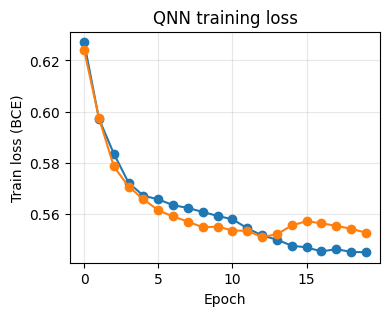

In [33]:
# Plot training loss

plt.figure(figsize=(4, 3))
plt.plot(history["loss"], marker='o')
plt.plot(history["val_loss"], marker='o')
plt.xlabel("Epoch")
plt.ylabel("Train loss (BCE)")
plt.title("QNN training loss")
plt.grid(alpha=0.3)
plt.show()


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 4.1 — Short answer
Comment briefly on the training and validation curves you obtained.
Does the loss decrease steadily? Do you see signs of underfitting or overfitting?
</div>

**Answer**: [Your answer here]

# Task 5: Evaluation on the test set

Finally, we evaluate the trained QNN on the **held-out test set**.

1. Compute predicted probabilities on the test set.  
2. Convert probabilities to class predictions using a 0.5 threshold.  
3. Compute and print:
   - test accuracy,  
   - confusion matrix,  
   - classification report (optional).


Test accuracy: 0.833
Confusion matrix [[TN, FP], [FN, TP]]:
[[21  6]
 [ 3 24]]


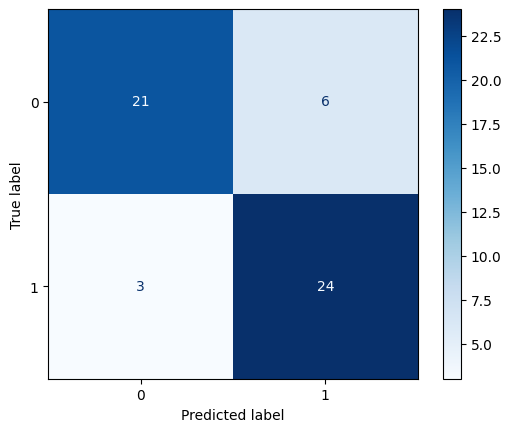

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        27
           1       0.80      0.89      0.84        27

    accuracy                           0.83        54
   macro avg       0.84      0.83      0.83        54
weighted avg       0.84      0.83      0.83        54



In [34]:
# Evaluation on test set

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device_torch)
        yb = yb.to(device_torch)

        probs = model(xb)  # (batch_size, 1)
        all_probs.append(probs.cpu())
        all_labels.append(yb.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert probabilities to class predictions
y_pred = (all_probs >= 0.5).int()
y_true = all_labels.int()

acc = accuracy_score(y_true.numpy(), y_pred.numpy())
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

print(f"Test accuracy: {acc:.3f}")
print("Confusion matrix [[TN, FP], [FN, TP]]:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.show()

print(classification_report(y_true.numpy(), y_pred.numpy()))


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question 5.1 — Short answer
Does the confusion matrix show any interesting asymmetry (e.g., more false positives than false negatives)?
</div>

**Answer**: [Your answer here]

# Bonus: Gradient inspection and barren plateaus

In this bonus exercise, you will perform a more detailed gradient inspection on your QNN to connect with the concept of barren plateaus.

We will focus on three aspects:

1. Gradient norms at initialization for different circuit depths (`n_layers`).  
2. Gradient norms during training (how they evolve across epochs).  
3. Distribution of per-parameter gradients at a given point in training.


You may reuse your QNN architecture from the main tasks (feature map, ansatz, QNode, and `QNNClassifier`), or define a simplified variant dedicated to this analysis.


## Bonus 0 — Helper: single-batch gradient computation

We start by writing a helper function that:

- Takes a model, a data loader, and a loss function.  
- Grabs one mini-batch from the loader.  
- Computes the loss and then the gradient of the loss w.r.t. `model.theta`.  
- Returns the L2 norm of that gradient, divided by the square root of the number of parameters (and optionally the gradient tensor itself).

We will reuse this helper in the following subtasks.


In [ ]:
# Bonus A.0 — Helper: compute gradient norm for one batch

# Normalized gradient norm computation
def gradient_norm_for_one_batch(model, data_loader, criterion, device=device_torch):
    """
    Compute the L2 norm of the gradient of the loss w.r.t. model.theta
    using a single batch from data_loader.
    """
    model.train()
    # Take the first batch only
    xb, yb = next(iter(data_loader))
    xb = xb.to(device)
    yb = yb.to(device)

    # Zero existing gradients
    model.zero_grad()

    # Forward pass
    preds = model(xb)
    loss = criterion(preds, yb)

    # Backward pass
    loss.backward()

    # Extract gradient of theta
    grad_theta = model.theta.grad  # tensor with same shape as theta
    grad_norm = torch.norm(grad_theta).item() / math.sqrt(grad_theta.numel())

    return grad_norm, grad_theta.detach().cpu(), loss.item()

# Quick sanity check (optional, only if model is already defined)
criterion = nn.BCELoss()
g_norm, g_tensor, loss_val = gradient_norm_for_one_batch(model, train_loader, criterion)
print("Gradient norm (one batch):", g_norm, "Loss:", loss_val)


## Bonus 1 — Gradient norms at initialization vs circuit depth

In this part, you will study how the gradient norm at random initialization depends on the circuit depth `n_layers`.

**Instructions:**

1. Choose a list of depths, e.g. `depth_list = [1, 2, 3]` (you may add more if runtime allows).  
2. For each depth:
   - Rebuild a fresh QNN (same architecture as in the main task, but with that `n_layers`).  
   - Randomly initialize the parameters (the default PyTorch initialization is fine).  
   - Compute the gradient norm on a single training batch using `gradient_norm_for_one_batch`.  
3. Store the gradient norms and print them (and optionally plot them).  
4. Comment on whether deeper circuits tend to show smaller gradient norms at initialization.

You can reuse your `QNNClassifier` class, but you will need to make `n_layers` configurable.


In [ ]:
# Bonus A.1 — Gradient norm vs depth at initialization

# Make sure you have a way to construct a QNNClassifier with a given n_layers.
# For example, you can wrap the model creation in a small factory function.

def make_qnn_model(n_layers, n_qubits):
    """
    Factory for QNNClassifier with given depth n_layers and n_qubits.
    Adjust theta_shape and ansatz accordingly.
    """
    # Example: theta_shape = (n_layers, n_qubits)
    theta_shape = (n_layers, n_qubits)
    model = QNNClassifier(theta_shape).to(device_torch)
    return model

criterion = nn.BCELoss()

depth_list = [1, 2, 3, 4, 5, 6, 7]  # you can add 4, 5, ... if time allows
grad_norms_depth = []

for depth in depth_list:
# -----YOUR CODE HERE-----

# ---YOUR CODE ENDS HERE---

# Optional: plot gradient norms vs depth
plt.figure(figsize=(4, 3))
plt.plot(depth_list, grad_norms_depth, marker="o")
plt.xlabel("n_layers (circuit depth)")
plt.ylabel("Gradient norm at init")
plt.title("Gradient norm vs depth at initialization")
plt.grid(alpha=0.3)
plt.show()


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus 1.1 — Interpretation
Comment on the gradient norms vs depth that you observed.

- Do deeper circuits tend to show smaller gradient norms at random initialization?  
- How does this relate qualitatively to the idea of barren plateaus (even in this small setup)?
</div>

**Answer**: [Your answer here]

## Bonus 2 — Gradient norm across training epochs

We now study how the gradient norm evolves during training for a fixed circuit depth.

**Instructions:**

1. Pick one depth (e.g. `n_layers = 2`).  
2. Train the QNN for a small number of epochs (e.g. 10) as in the main assignment.  
3. At each epoch:
   - After the weight update, compute the gradient norm on one batch using `gradient_norm_for_one_batch`.  
   - Store this value in a list `grad_norms_epochs`.  
4. Plot gradient norm vs epoch, and compare this with the training loss curve.  
5. Comment on whether gradients tend to shrink as training progresses.

> Hint: You can reuse your training loop, but add a call to `gradient_norm_for_one_batch` at the end of each epoch, using the current model parameters.


In [ ]:
# Bonus A.2 — Gradient norm vs epoch for a fixed depth

# Choose a depth
depth_for_training = 2
model_train = make_qnn_model(depth_for_training, n_qubits)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_train.parameters(), lr=0.02)

n_epochs_bonus = 10
losses_epochs = []
grad_norms_epochs = []

for epoch in range(1, n_epochs_bonus + 1):
    model_train.train()
    epoch_loss = 0.0
    # -----YOUR CODE HERE-----

    # ---YOUR CODE ENDS HERE---
    grad_norms_epochs.append(g_norm)

    print(f"Epoch {epoch:02d}/{n_epochs_bonus} - Loss: {epoch_loss:.4f}, Grad norm: {g_norm:.4e}")

# Plot loss and gradient norm vs epoch
fig, ax1 = plt.subplots(figsize=(5, 3))

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train loss (BCE)", color="C0")
ax1.plot(range(1, n_epochs_bonus+1), losses_epochs, marker="o", color="C0", label="Loss")
ax1.tick_params(axis="y", labelcolor="C0")

ax2 = ax1.twinx()
ax2.set_ylabel("Gradient norm", color="C1")
ax2.plot(range(1, n_epochs_bonus+1), grad_norms_epochs, marker="s", color="C1", label="Grad norm")
ax2.tick_params(axis="y", labelcolor="C1")

fig.tight_layout()
plt.title(f"Depth = {depth_for_training}: Loss and gradient norm vs epoch")
plt.show()


<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus 2.1 — Observation
Describe how the gradient norm changes during training: Does it decrease, stay roughly constant, or fluctuate?
</div>

**Answer**: [Your answer here]

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus 2.2 — Interpretation
How does this relate to the changes in the training loss?
</div>

**Answer**: [Your answer here]

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus 2.3 — Interpretation
In general, if our QNN suffered from a barren plateau, how would that affect the gradient norm?
</div>

**Answer**: [Your answer here]

## Bonus 3 — Distribution of per-parameter gradients

So far, we have focused on the normalized L2 norm of the gradient.  
Now, we take a closer look at the distribution of individual gradient components.

**Instructions:**

1. Using a model (for some depth), compute the gradient of the loss w.r.t. `model.theta` on one batch.  
2. Extract all gradient entries as a 1D array and plot a histogram of their values.  
Do step 1 and 2:
   - once at initialization, and  
   - once after training, and compare the two histograms.

This gives a sense of whether gradients are broadly distributed or tend to concentrate tightly around zero.


In [ ]:
# Bonus A.3 — Gradient distribution (histogram)

def gradient_histogram(model, data_loader, criterion, device=device_torch, title=""):
    """
    Compute gradients on one batch and plot a histogram of gradient values.
    """
    model.train()
    xb, yb = next(iter(data_loader))
    xb = xb.to(device)
    yb = yb.to(device)
    
    # -----YOUR CODE HERE-----

    # ---YOUR CODE ENDS HERE---

    grad_vals = model.theta.grad.detach().cpu().numpy().ravel()

    plt.figure(figsize=(4, 3))
    plt.hist(grad_vals, bins=40, alpha=0.8)
    plt.xlabel("Gradient value")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

    print(f"{title} — mean grad: {grad_vals.mean():.2e}, std grad: {grad_vals.std():.2e}")
    return grad_vals

criterion = nn.BCELoss()
depth = 2
# Example: histogram at initialization for specific depth
model_init = make_qnn_model(depth, n_qubits)
print("Gradient distribution at initialization (depth=2):")
_ = gradient_histogram(model_init, train_loader, criterion, device=device_torch,
                       title="Gradients at init (depth=2)")

# Example: histogram after training for depth=2 (reuse model_train from Bonus A.2 if available)
try:
    print("Gradient distribution after training (depth=2):")
    _ = gradient_histogram(model_train, train_loader, criterion, device=device_torch,
                           title="Gradients after training (depth=2)")
except NameError:
    print("model_train not found. Run Bonus A.2 first or train a model for this analysis.")


Compare the gradient histograms you obtained:

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus 3.1 — Observation
Are gradients broadly distributed or sharply concentrated near zero?  
</div>

**Answer**: [Your answer here]

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus 3.2 — Short answer
Does training make them more or less concentrated?  
</div>

**Answer**: [Your answer here]

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Question Bonus 3.3 — Reflection
How would a highly concentrated distribution of very small gradients relate to barren plateaus?
</div>

**Answer**: [Your answer here]

# Feedback to us

<div style="max-width: 1200px; margin: auto; border: 1px solid #004791; border-left: 6px solid #004791; border-radius: 6px; padding: 0.8em 1em; background-color: #1b1b1bff; color: #eee;">

### Optional question
Was there any part of the tasks where you struggled for some "unnecessary" reason? (Errors in the notebook, bad instructions etc.)

</div>

**Answer**: [Your optional answer here]

# Disclosure of AI Usage (Mandatory)
Fill in this part disclosing any AI usage before submitting the assignment by describing your use of LLMs or other AI-based tools in this assignment.

For each task, we ask you to provide information about:
- **Tools/models used**.
- **Per‑task usage**: for each task, a brief summary of what the tool was used for.
- **Prompts/transcripts**: main prompts or a summary of interactions (a link or screenshot is acceptable if long).
- **Validation**: how you checked and verified the correctness of AI-generated outputs (tests run, docs consulted, comparisons, plots etc.).

Disclosure:
- **Task 0**: [...describe your use...]

- **Task 1**: [...describe your use...]

- **Task 2**: [...describe your use...]

- **Task 3**: [...describe your use...]

- **Task 4**: [...describe your use...]

- **Task 5**: [...describe your use...]

- **Bonus 1**: [...describe your use...]

- **Bonus 2**: [...describe your use...]

- **Bonus 3**: [...describe your use...]

If you did not use any AI tools for a given exercise, specify this by writing "None". If you did not complete the bonus exercises, you can leave those fields empty.